# Aggregate multiple datasets to one

Thsi section defines some stuff for running the script. 

In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
import os
import itertools
import numpy as np
import pandas as pd

from results_helper import (
    MODELS, 
    MODELS_FULL,
    MODELS_SHORT,
    PROMPT_METHODS,
    DATASETS,
    DATASETS_FULL,
    DATASET_LENS,
    TARGET_DATASET,
    ROBUST_PATH,
    DATASET_PREFERENCES,
    METRICS,
    METRIC_LABELS,
    RELEVANCE, 
    RELEVANCE_DICT, 
)

from results_helper import aggregate, split_to_df_by_dataset
results_dict = aggregate(relevance=["relevant", "irrelevant", "irrelevant_set"], verbose=False, use_eval=True)

Found 37/156 full datasets


In [70]:
results_dict = split_to_df_by_dataset(results_dict, verbose=True)
print(results_dict)
results_dict.print_data()

MultiKeyDict with 304 entries:
Custom Keys: ['relevance', 'method', 'model', 'dataset', 'field']
Categorical Fields:
  - relevance(3): ['relevant', 'irrelevant_set', 'irrelevant']
  - method(4): ['direct', 'cot', 'icl', 'self_critic']
  - model(13): ['Llama-3.1-8B-Instruct', 'Llama-3.3-70B-Instruct-Turbo-Free', 'Mistral-7B-Instruct-v0.3', 'janus-7b', 'Mixtral-8x7B-Instruct-v0.1', 'gpt-4o-mini-2024-07-18', 'DeepSeek-R1-Distill-Llama-70B-free', 'gemma-2-9b-it', 'gemma-2-27b-it', 'Qwen3-8B', 'Qwen3-8B_thinking', 'Qwen3-32B', 'Qwen3-32B_thinking']
  - dataset(4): ['commonsense_qa', 'mmlu', 'truthful_qa', 'full']
  - Fields(len 2): ['dataset_path', 'df']

Data:
  - ('relevant', 'direct', 'Llama-3.1-8B-Instruct', 'full', 'dataset_path'): results/mcq_results/relevant/direct/full/Llama-3.1-8B-Instruct-direct-full_eval.csv
  - ('relevant', 'direct', 'Llama-3.3-70B-Instruct-Turbo-Free', 'full', 'dataset_path'): results/mcq_results/relevant/direct/full/Llama-3.3-70B-Instruct-Turbo-Free-direct-ful

## Table of scores

BR = 1-(Robust(q, P) | Correct_no_pref(q))

RDR = 1-(Robust(q, P) / Correct_no_pref(q))

AFR = 1 - (Robust(q, P) / Correct_pref(q, P))

PVR = (Correct_nopref(q) & Correct_pref(q, P)) / (Correct_nopref(q) | Correct_pref(q, P))

Compute per model, per dataset and full dataset

In [71]:
from results_helper import (MODELS_SHORT_DICT, compute_metrics, print_metric_table)

# Compute metrics
results_dict = compute_metrics(results_dict, verbose=False)

# # Debug print values
# print_metric_table(
#     results_dict,
#     # relevances=["relevant"],
# )

## Scatter Plot of AVF vs BR

In [72]:
## TBD Code deleted by accident
from results_helper import filter_axis, named_scatter

scatter_metric_combos = [
    ("BR", "AFR", "RER")
]

for combo in scatter_metric_combos:
    metric1, metric2, metric3 = combo
    
    data, order = results_dict.get_field_matrix(
        field=[metric1, metric2, metric3],
        fixed_keys={
            "dataset": "full",
            "relevance": "relevant",
            "method": "direct",
        },
        axis_keys=["model"]
    )
    data = np.array(data)
    print(data.shape, order)
    
    data, _, scatter_model_names = filter_axis(
        data,
        axis=1,
        labels_to_filter=MODELS_SHORT,
    )
    print(data.shape, scatter_model_names)

    named_scatter(
        data[0],
        data[1],
        keys=scatter_model_names,
        title=f"{metric2} vs {metric1} Scatter Plot",
        xlabel=METRIC_LABELS[metric1],
        ylabel=METRIC_LABELS[metric2],
        scores=data[2],
        show=False,
    )

(3, 13) ['field', 'model']
(3, 12) ['Llama3-8B', 'Llama3-70B', 'Mistral-7B', 'Janus-7B', 'Mixtral-8x7B', 'GPT-4o-mini', 'DeepSeek-R1-70B', 'Gemma-2-9B', 'Gemma-2-27B', 'Qwen3-8B', 'Qwen3-8B-Thinking', 'Qwen3-32B']
Modifying


## Horizontal Bidirectional Bar Plot for Relevant/Mixed

In [73]:
from results_helper import rel_irrel_backback_barplot, filter_axis

matrices = []

for metric in METRICS:
    data, order = results_dict.get_field_matrix(
        field=metric,
        fixed_keys={
            "method": "direct",
            "dataset": "full",
        },
        axis_keys=["model", "relevance"]
    )
    data = np.array(data).squeeze()
    print(data.shape)
    data, _, model_names_rel_hb = filter_axis(
        data, 
        axis=0,
        filter_val=None,
        labels_to_filter=MODELS_SHORT,
    )
    print(data.shape)
    
    rel_irrel_backback_barplot(
        data[:, 0],
        data[:, 1],
        models=model_names_rel_hb,
        title=f"{metric} by Relevance",
        show=False,
    )



(13, 3)
(5, 3)
(13, 3)
(5, 3)
(13, 3)
(5, 3)
(13, 3)
(5, 3)


## Horizontal Bar Plot for Relevant/Irrelevant/Mixed

In [74]:
from results_helper import relevance_hbarplot, filter_axis

matrices = []

for metric in METRICS:
    data, order = results_dict.get_field_matrix(
        field=metric,
        fixed_keys={
            "method": "direct",
            "dataset": "full",
        },
        axis_keys=["model", "relevance"]
    )
    data = np.array(data).squeeze()
    print(data.shape)
    data, _, model_names_rel_hb = filter_axis(
        data, 
        axis=0,
        filter_val=None,
        labels_to_filter=MODELS_SHORT,
    )
    print(data.shape)
    
    relevance_hbarplot(
        data,
        relevance_list=RELEVANCE,
        models=model_names_rel_hb,
        title=f"{metric} by Relevance",
        xlabel=METRIC_LABELS[metric],
        show=False,
    )



(13, 3)
(5, 3)
(13, 3)
(5, 3)


/Users/danielhou/Code/pref_aligner/results_helper.py:1033: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])
/Users/danielhou/Code/pref_aligner/results_helper.py:1033: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])


(13, 3)
(5, 3)
(13, 3)
(5, 3)


/Users/danielhou/Code/pref_aligner/results_helper.py:1033: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])
/Users/danielhou/Code/pref_aligner/results_helper.py:1033: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])


## Horizontal Bar Plot for Prompt Methods

In [75]:
from results_helper import method_hbarplot, filter_axis

matrices = []

metrics_wo_pvr = ["BR", "RER", "AFR"]
for metric in metrics_wo_pvr:
    data, order = results_dict.get_field_matrix(
        field=metric,
        fixed_keys={
            "relevance": "relevant",
            "dataset": "full",
        },
        axis_keys=["model", "method"]
    )
    data = np.array(data).squeeze()
    print(data.shape)

    data, _, model_names_hb = filter_axis(
        data, 
        axis=0,
        filter_val=None,
        labels_to_filter=MODELS_SHORT,
    )
    print(data.shape)
    matrices.append(data)

method_hbarplot(
    matrices,
    methods=PROMPT_METHODS,
    models=model_names_hb,
    subplot_titles=metrics_wo_pvr,
    title="Metrics with Various Prompting Methods",
    show=False,
)


(13, 4)
(4, 4)
(13, 4)
(4, 4)
(13, 4)
(4, 4)


## MC Return Valid Answer Drop in Probability

(2, 13)
[[ 0.4162042   0.04162042  0.8462819   1.8312986   0.87402886  3.135405
  21.947836    0.263596    0.4162042  10.474473   17.064373   11.792453  ]
 [ 0.72142065  0.09711432  1.2208657   2.691454    1.0127636   8.837403
  19.866816    0.7630411   0.7352941  10.668701   14.095449   17.216982  ]]
(2, 12)


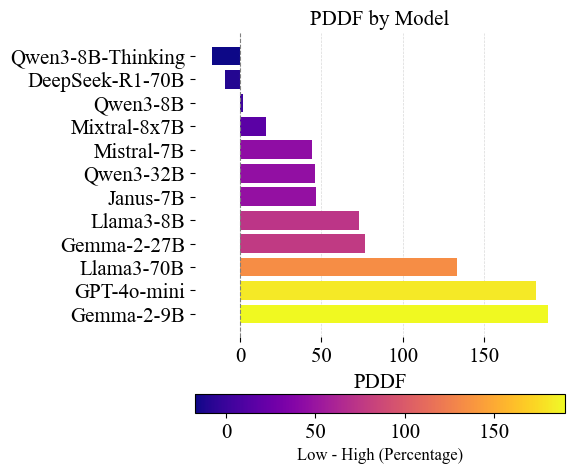

In [80]:
from results_helper import missing_answer_hbarplot, missing_answer_diffplot, filter_axis

data, order = results_dict.get_field_matrix(
    field=["NoPrefInvalid", "PrefInvalid"],
    fixed_keys={
        "dataset": "full",
        "method": "direct",
        "relevance": "relevant",
    },
    axis_keys=["model"]
)
data = np.array(data).squeeze()
print(data.shape)
data = data[:, :-1].astype(np.float32)
models_ref = MODELS[:-1].copy()
print(data)

# Filter by None
data, _, model_names_hb = filter_axis(
    data, 
    axis=0,
    filter_val=None,
    labels_to_filter=MODELS_SHORT,
)
# Filter by 0
data, _, model_names_hb = filter_axis(
    data, 
    axis=0,
    filter_val=0.0,
    labels_to_filter=model_names_hb,
)
print(data.shape)

# missing_answer_hbarplot(
#     data, 
#     keys=models_ref,
#     title="Missing Answer Rate by Model",
#     xlabel="Missing Answer Rate",
#     show=True
# )
low  = data[0, :]
high = data[1, :]
diff = (high - low) / low * 100

missing_answer_diffplot(
    diff,
    keys=models_ref,
    title="PDDF by Model",
    xlabel="PDDF",
    show=True
)


## PVR Plot like the one above

(13,)
[28.31085   9.768977 34.61265  45.887745 25.628742 15.749559 30.539873
 15.831135 11.58713  26.321606 30.437199 27.903732]


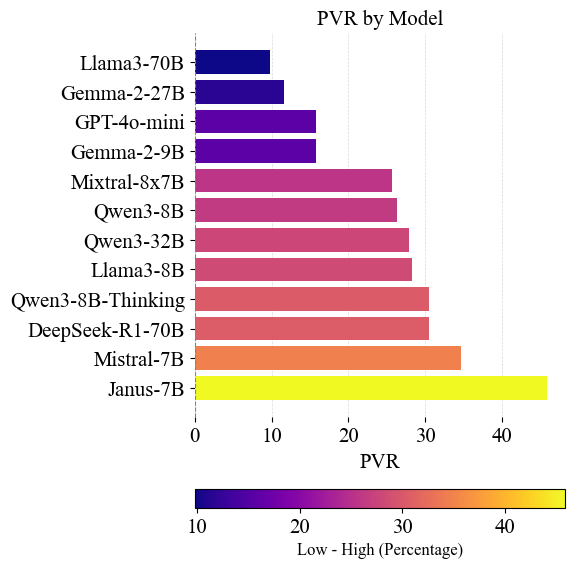

In [81]:
from results_helper import missing_answer_diffplot, filter_axis

data, order = results_dict.get_field_matrix(
    field=["PVR"],
    fixed_keys={
        "dataset": "full",
        "method": "direct",
        "relevance": "relevant",
    },
    axis_keys=["model"]
)
data = np.array(data).squeeze()
print(data.shape)
data = data[:-1].astype(np.float32)
models_ref = MODELS[:-1].copy()
print(data)

missing_answer_diffplot(
    data,
    keys=models_ref,
    title="PVR by Model",
    xlabel="PVR",
    show=True
)


## Analyzing accuracy of sampled vs full preferences

1. Llama-3.1-8B
2. Janus-7B

here
dict_values([np.float64(0.7058823529411765), np.float64(0.7352941176470589), np.float64(0.7745098039215687), np.float64(0.6764705882352942), np.float64(0.7745098039215687), np.float64(0.8137254901960784), np.float64(0.7156862745098039), np.float64(0.6470588235294118), np.float64(0.6764705882352942), np.float64(0.7326732673267327), np.float64(0.7128712871287128), np.float64(0.7524752475247525)])
here
here
dict_values([np.float64(0.6), np.float64(0.6617021276595745), np.float64(0.597872340425532), np.float64(0.6574468085106383), np.float64(0.5723404255319149), np.float64(0.6297872340425532), np.float64(0.6063829787234043), np.float64(0.6042553191489362), np.float64(0.6234042553191489), np.float64(0.5936170212765958), np.float64(0.6085106382978723)])
here
here
dict_values([np.float64(0.576271186440678), np.float64(0.6271186440677966), np.float64(0.4067796610169492), np.float64(0.5423728813559322), np.float64(0.6779661016949152), np.float64(0.4827586206896552), np.float64(0.5689655172

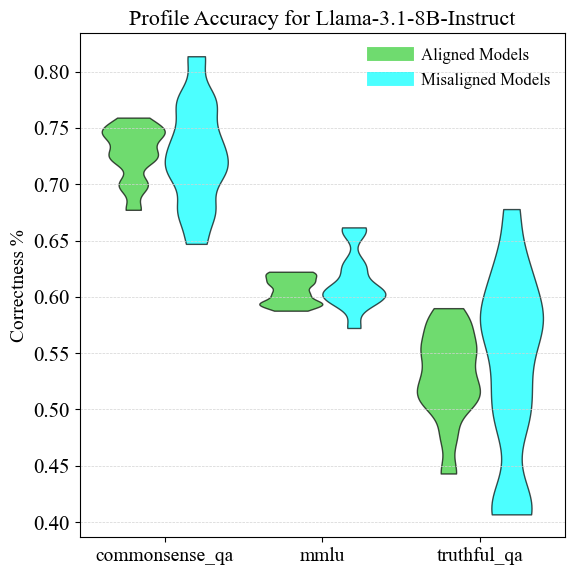

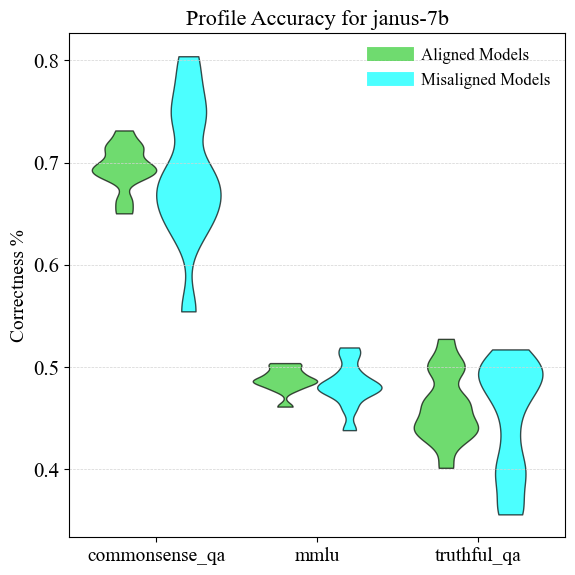

In [126]:
from results_helper import compare_profile_accuracy
# Llama-8B

llama_indiv_dataset_paths = [
    "Llama-3.1-8B-Instruct_final.csv",
    "Llama-3.1-8B-Instruct_0.8158839580640529_final.csv",
    "Llama-3.1-8B-Instruct_final.csv",
]

compare_profile_accuracy(
    "Llama-3.1-8B-Instruct",
    llama_indiv_dataset_paths,
    results_dict,
    show=True,
)

janus_indiv_dataset_paths = [
    "janus-7b_final.csv",
    "janus-7b_final.csv",
    "janus-7b_final.csv",
]

compare_profile_accuracy(
    "janus-7b",
    janus_indiv_dataset_paths,
    results_dict,
    show=True,
)